In [2]:
import pandas as pd
df = pd.read_csv('cybersecurity_attacks.csv')
df.head()
#mlp and/or nn to predict attack type and access vector
#df.shape


,Timestamp,Source IP Address,Destination IP Address,Source Port,Destination Port,Protocol,Packet Length,Packet Type,Traffic Type,Payload Data,...,Action Taken,Severity Level,User Information,Device Information,Network Segment,Geo-location Data,Proxy Information,Firewall Logs,IDS/IPS Alerts,Log Source
0,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,Qui natus odio asperiores nam. Optio nobis ius...,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,NaN,Server
1,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,Aperiam quos modi officiis veritatis rem. Omni...,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",NaN,Log Data,NaN,Firewall
2,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,Perferendis sapiente vitae soluta. Hic delectu...,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,Totam maxime beatae expedita explicabo porro l...,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",NaN,NaN,Alert Data,Firewall
4,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,Odit nesciunt dolorem nisi iste iusto. Animi v...,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# Drop irrelevant or high-cardinality columns
drop_cols = [
    'Timestamp', 'Source IP Address', 'Destination IP Address',
    'Payload Data', 'Attack Signature', 'User Information',
    'Device Information', 'Geo-location Data', 'Proxy Information',
    'Firewall Logs', 'IDS/IPS Alerts', 'Log Source'
]

# Define features and targets
features = df.drop(columns=drop_cols + ['Anomaly Scores', 'Traffic Type'])
target_anomaly_type = df['Anomaly Scores']
target_traffic_type = df['Traffic Type']

# Identify categorical and numeric columns
categorical_cols = features.select_dtypes(include='object').columns.tolist()
numeric_cols = features.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Encode target variables
anomaly_type_encoder = LabelEncoder()
traffic_type_encoder = LabelEncoder()

y_attack = anomaly_type_encoder.fit_transform(target_anomaly_type)
y_traffic = traffic_type_encoder.fit_transform(target_traffic_type)

# Train/test split
X_train, X_test, y_attack_train, y_attack_test, y_traffic_train, y_traffic_test = train_test_split(
    features, y_attack, y_traffic, test_size=0.2, random_state=42
)

In [4]:
features.shape

(40000, 11)

In [5]:
#!pip3 install torch 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []

        # Input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Final output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Example: input_size=10, two hidden layers with 64 and 32 units, output_size=1 (for regression or binary classification)
mlp = MLP(input_size=10, hidden_sizes=[64, 32], output_size=1)

# Print model
print(mlp)


MLP(
  (model): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [ ]:
#logistic regression 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

features = df[['Traffic Type', 'Anomaly Scores']]
target = df['Severity Level']
features_encoded = pd.get_dummies(features, columns=['Traffic Type'], drop_first=True)
label_encoder = LabelEncoder()
target_encoded = label_encoder.fit_transform(target)
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target_encoded, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=200, class_weight='balanced')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# struggles to predict low, accuracy is not great

              precision    recall  f1-score   support

        High       0.32      0.10      0.15      2598
         Low       0.33      0.42      0.37      2673
      Medium       0.34      0.47      0.40      2729

    accuracy                           0.33      8000
   macro avg       0.33      0.33      0.31      8000
weighted avg       0.33      0.33      0.31      8000



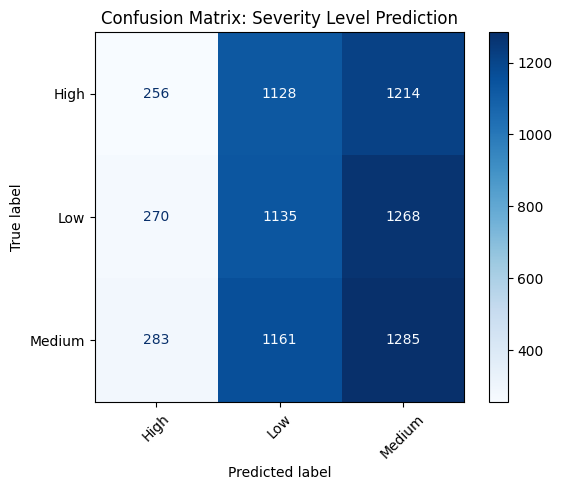

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix: Severity Level Prediction")
plt.show()
#not ideal

/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/evahuang/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

        High       0.32      0.59      0.42      2598
         Low       0.00      0.00      0.00      2673
      Medium       0.34      0.41      0.37      2729

    accuracy                           0.33      8000
   macro avg       0.22      0.33      0.26      8000
weighted avg       0.22      0.33      0.26      8000



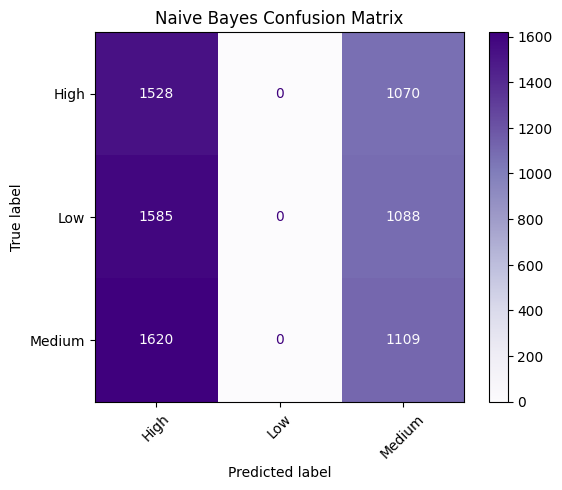

In [11]:
#gaussian naivebayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)
print(classification_report(y_test, y_pred_nb, target_names=label_encoder.classes_))
cm = confusion_matrix(y_test, y_pred_nb)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Purples', xticks_rotation=45)
plt.title("Naive Bayes Confusion Matrix")
plt.show()